In [1]:
import cv2
import sys
import copy
import scipy.signal
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from PIL import Image
from rdfpy import rdf
import imagedataextractor as ide

from i2sas.data import parse_datathief
from i2sas.general import get_volume_fraction, get_areas
from i2sas.particles_on_plane import (rdf2d_with_3d_vol, 
                                      compute_structure_factor_3d, 
                                      polydisperse_spherical_formfactor)
from i2sas.infinite_cylinders import (compute_structure_factor_2d, 
                                      polydisperse_infinite_length_cylindrical_formfactor)

### Particles on a Plane

In [2]:
data_path = 'data/wu/data.txt'
exp_data = parse_datathief(data_path)
exp_x, exp_y = exp_data[:, 0], exp_data[:, 1]

In [3]:
im_path = 'data/wu/image.png'
data = ide.extract(im_path, seg_tu=0.06)

2022-01-21 14:48:00,395 : INFO : Input is an image of type png.
2022-01-21 14:48:03,868 : INFO : Scalebar detection successful.
2022-01-21 14:48:59,525 : INFO : Particle segmentation successful.
2022-01-21 14:49:04,794 : INFO : Extraction successful - Found 929 particles.


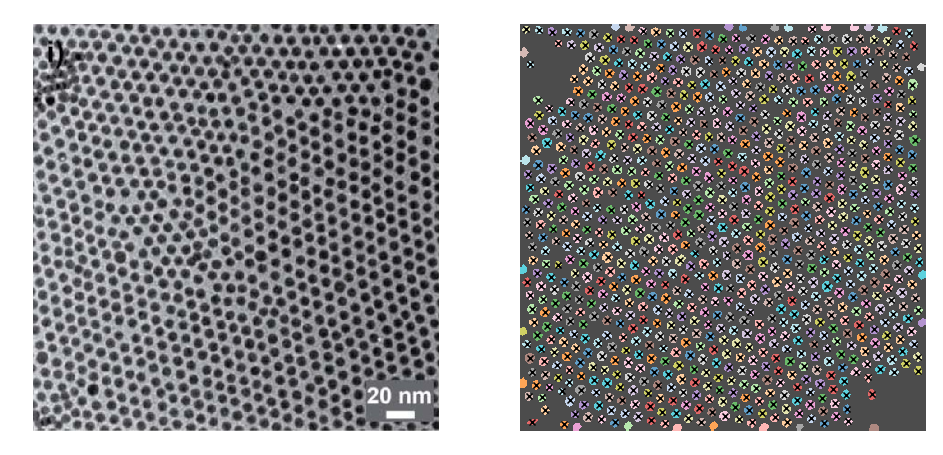

In [4]:
image = np.array(Image.open(im_path))

seg_cmap = copy.copy(matplotlib.cm.tab20)
seg_cmap.set_bad(color='k')

seg = data.segmentation.astype(float)

# bpartis over-estimates small particles, so erode
seg = cv2.erode(seg, np.ones((7, 7),np.uint8), iterations=1)
# set background to nan for plotting
seg[seg == 0.0] = np.nan

fig, axes = plt.subplots(1, 2, figsize=(16, 8))
for ax in axes:
    ax.axis('off')
axes[0].imshow(image)
axes[1].matshow(seg, cmap=seg_cmap, alpha=0.7)
axes[1].scatter(data.valid_coords[:, 1], data.valid_coords[:, 0], marker='x', color='k')
plt.show()

In [5]:
sb_length_angstrom = 200.0
sb_length_px = 58  # measured from image
conversion = sb_length_angstrom / sb_length_px

coords = data.valid_coords
coords = coords * conversion
coords.shape

(904, 2)

In [6]:
print(coords.max(axis=0), 'Å')
print('Image Dimensions: {} Å'.format(np.array(image.shape[:2]) * conversion))

[3058.62068966 3048.27586207] Å
Image Dimensions: [3110.34482759 3103.44827586] Å


In [7]:
g_r, radii, rho = rdf2d_with_3d_vol(coords, dr=5/6, progress=True)
g_r = scipy.signal.savgol_filter(g_r, window_length=31, polyorder=2)
len(g_r)

1443

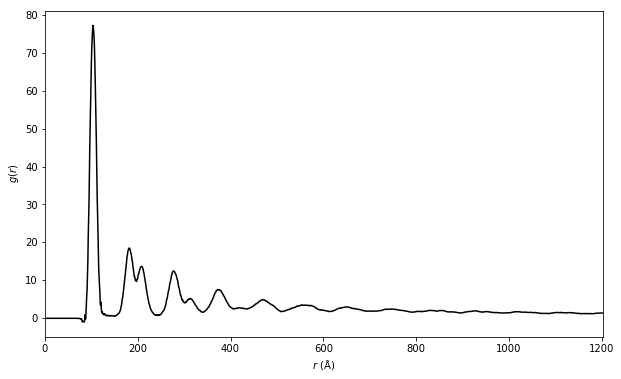

In [8]:
plt.figure(figsize=(10, 6))
plt.plot(radii, g_r, color='k')
plt.xlim(0.0, np.max(radii))
plt.ylabel(r'$g(r)$')
plt.xlabel(r'$r$ (Å)')
plt.show()

In [9]:
areas = get_areas(seg)
ave_r = np.mean(np.sqrt(areas/np.pi)) * conversion
std_r = np.std(np.sqrt(areas/np.pi)) * conversion
ave_vol = (4/3)*np.pi*ave_r**3
vol_frac = get_volume_fraction(seg)

dict(zip(['ave_r', 'std_r', 'vol_frac', 'ave_vol'], [ave_r, std_r, vol_frac, ave_vol]))

{'ave_r': 33.735534411497454,
 'std_r': 2.2824237891579946,
 'vol_frac': 0.34567750677506776,
 'ave_vol': 160824.1972037908}

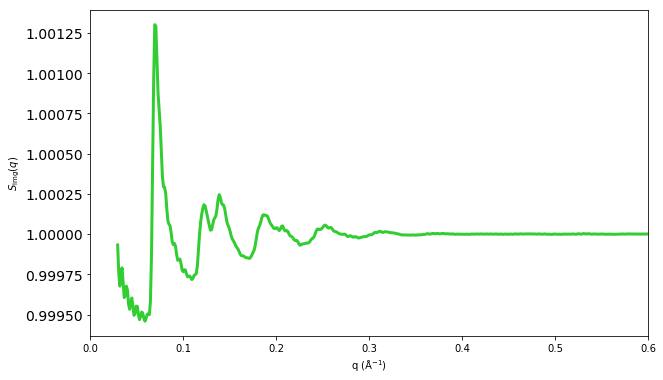

In [10]:
structure_factor, q = compute_structure_factor_3d(g_r, radii, rho, qmax=0.6)
q = q[25:]
structure_factor = structure_factor[25:]

plt.figure(figsize=(10, 6))
plt.plot(q, structure_factor, lw=3, color='limegreen')
plt.ylabel(r'$S_{\mathrm{img}}(q)$')
plt.xlabel(r'q (Å$^{-1}$)')
plt.xlim(0.0, np.max(q))
plt.yticks(fontsize=14)
plt.show()

In [11]:
formfactor = polydisperse_spherical_formfactor(q, ave_r, std_r, vol=True)

I_q = vol_frac*structure_factor*formfactor

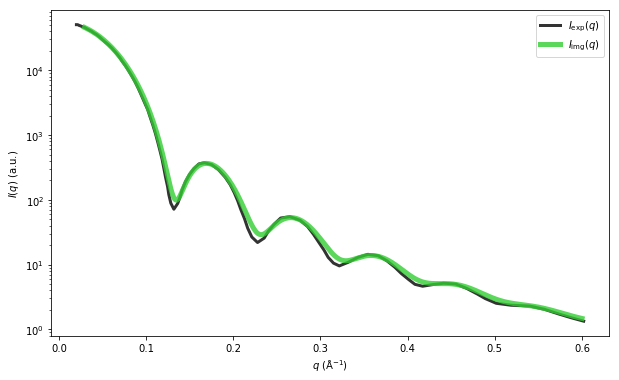

In [12]:
plt.figure(figsize=(10, 6))
plt.plot(exp_x, exp_y, color='k', label='$I_{\mathrm{exp}}(q)$', lw=3, alpha=0.8)
plt.plot(q, I_q, color='limegreen', label='$I_{\mathrm{img}}(q)$', lw=5, alpha=0.8)
plt.yscale('log')
plt.ylabel('$I(q)$ (a.u.)')
plt.xlabel('$q$ (Å$^{-1})$')
ax = plt.gca()
ax.get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
plt.legend()
plt.show()

### Infinite Parallel Cylinders

In [13]:
data_path = 'data/kelly/data.txt'
exp_data = parse_datathief(data_path)
exp_x, exp_y = exp_data[:, 0], exp_data[:, 1]

In [14]:
im_path = 'data/kelly/image.jpg'
data = ide.extract(im_path, seg_tu=0.06)
image = np.array(Image.open(im_path))

2022-01-21 14:49:25,808 : INFO : Input is an image of type jpeg.
2022-01-21 14:49:35,834 : INFO : Scalebar detection failed. Measurements will be given in units of pixels.
2022-01-21 14:50:24,822 : INFO : Particle segmentation successful.
2022-01-21 14:50:31,010 : INFO : Extraction successful - Found 344 particles.


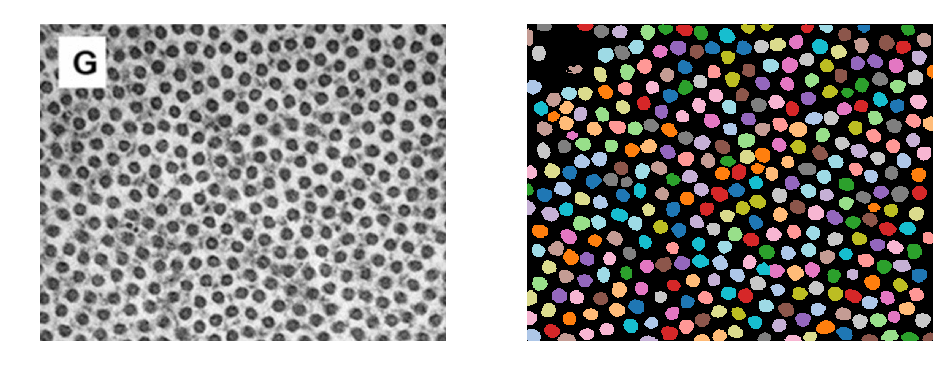

In [15]:
# visualize segmentation
seg_cmap = copy.copy(matplotlib.cm.tab20)
seg_cmap.set_bad(color='k')

seg = data.segmentation.astype(float)

# set background to nan for plotting
seg[seg == 0.0] = np.nan

fig, axes = plt.subplots(1, 2, figsize=(16, 8))
for ax in axes:
    ax.axis('off')
axes[0].imshow(image)
axes[1].matshow(seg, cmap=seg_cmap)
plt.show()

In [16]:
sb_length_A = 1000  # A 
sb_length_px = 177.0  # measured from image
conversion = sb_length_A / sb_length_px

coords = data.valid_coords
coords = coords * conversion
coords.shape

(316, 2)

In [17]:
print(coords.max(axis=0), 'A')
print('Image Dimensions: {} A'.format(np.array(image.shape[:2]) * conversion))

[ 8107.34463277 10389.83050847] A
Image Dimensions: [ 8293.78531073 10621.46892655] A


In [18]:
areas = get_areas(seg)
radiuses = np.sqrt(areas/np.pi) * conversion
ave_r = np.mean(radiuses) 
std_r = np.std(np.sqrt(areas/np.pi)) * conversion
ave_vol = (4/3)*np.pi*ave_r**3
vol_frac = get_volume_fraction(seg)
number_density = len(coords) / np.prod(np.array(image.shape[:2]) * conversion)

dict(zip(['ave_r', 'std_r', 'vol_frac', 'ave_vol', 'number_density'], 
         [ave_r, std_r, vol_frac, ave_vol, number_density]))

{'ave_r': 183.2847139818936,
 'std_r': 16.4728634984928,
 'vol_frac': 0.41544872166502406,
 'ave_vol': 25790950.48782982,
 'number_density': 3.5871514290683514e-06}

In [19]:
g_r, radii = rdf(coords, dr=20.0, rcutoff=0.65)
g_r = scipy.signal.savgol_filter(g_r, window_length=31, polyorder=2)
g_r = np.maximum(0.0, g_r)
len(g_r)

130

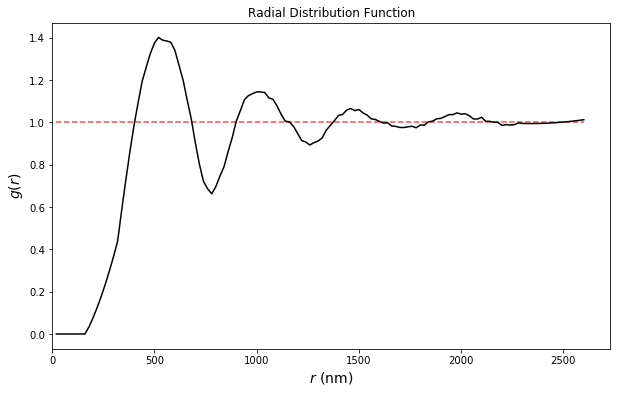

In [20]:
plt.figure(figsize=(10, 6))
plt.title('Radial Distribution Function')
plt.plot(radii, g_r, color='k')
plt.hlines(1.0, np.min(radii), np.max(radii), color='r', linestyle='--', alpha=0.7)
plt.xlim(0.0)
plt.ylabel(r'$g(r)$', fontsize=14)
plt.xlabel(r'$r$ (nm)', fontsize=14)
plt.show()

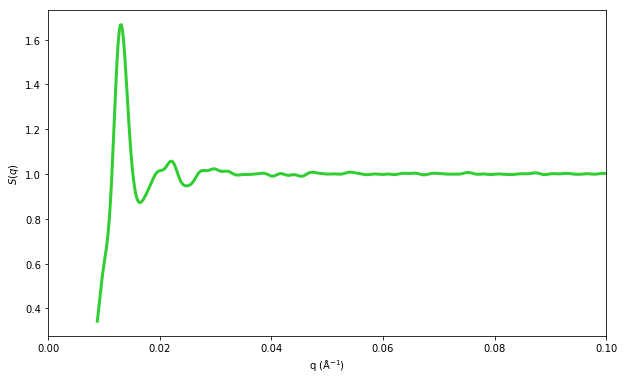

In [21]:
q, S_q = compute_structure_factor_2d(radii, g_r, number_density, qmax=0.1)
q = q[45:]
S_q = S_q[45:]

plt.figure(figsize=(10, 6))
plt.plot(q, S_q, lw=3, color='limegreen')
plt.ylabel(r'$S(q)$')
plt.xlabel(r'q (Å$^{-1}$)')
plt.xlim(0.0, np.max(q))
plt.yticks()
plt.show()

In [22]:
formfactor = polydisperse_infinite_length_cylindrical_formfactor(q, ave_r, std_r*1.0)
formfactor = formfactor * 100  # arbitrarily multipy by 10^2 so exp and img have similar magnitudes. 
I_q = vol_frac*S_q*formfactor

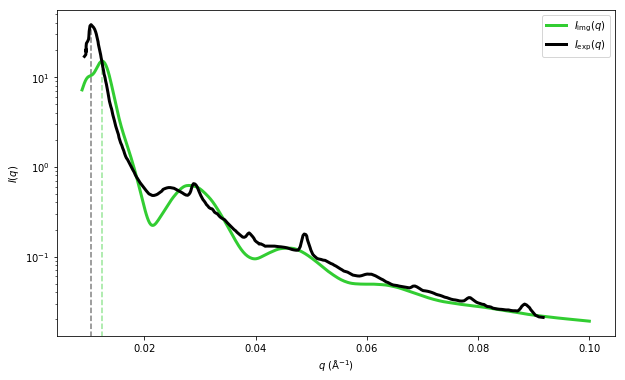

In [23]:
plt.figure(figsize=(10, 6))
plt.plot(q, I_q + 0.01, color='limegreen', label=r'$I_{\mathrm{img}}(q)$', lw=3)
plt.plot(exp_x, exp_y, color='k', label=r'$I_{\mathrm{exp}}(q)$', lw=3)
plt.vlines(exp_x[np.argmax(exp_y)], 0.0, np.max(exp_y), linestyle='--', alpha=0.5, color='k')
plt.vlines(q[np.argmax(I_q)], 0.0, np.max(I_q), linestyle='--', alpha=0.5, color='limegreen')


plt.yscale('log')
plt.ylabel('$I(q)$')
plt.xlabel('$q$ (Å$^{-1})$')
plt.yticks()
ax = plt.gca()
ax.get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
plt.legend()
plt.show()